# 图书推荐系统

**参考基础：https://blog.csdn.net/ChenVast/article/details/82620772  **  
数据集：http://www2.informatik.uni-freiburg.de/~cziegler/BX/ Book-Crossing Dataset

In [2]:
#导入相关包
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os, sys
import re
import seaborn as sns #Seaborn其实是在matplotlib的基础上进行了更高级的API封装

## 特征工程

### book数据处理

In [3]:
#加载数据并进行观察
#图书
books = pd.read_csv('dataset/BX-Books.csv', sep = ';', error_bad_lines=False,encoding='latin-1')

# sep = ';'设定拆分间隔
# error_bad_lines=False来忽略这种错误(某一行出现的字段大于第一行)
#encoding: 编码方式mysql 的默认字符集 latin1 

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [4]:
#设定列标签
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

In [5]:
books.head(5)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


**官方关于book数据解释  **  
X-Books  
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.   
BX-书籍  
书籍由各自的ISBN标识。已从数据集中删除无效的ISBN。此外，从Amazon Web Services获得了一些基于内容的信息（“Book-Title”，“Book-Author”，“Year-Of-Publication”，“Publisher”）。请注意，如果有多位作者，则仅提供第一个作者。还给出了链接到封面图像的URL，以三种不同的形式出现（`Image-URL-S`，`Image-URL-M`，`Image-URL-L`），即小，中，大。这些URL指向Amazon网站。


In [6]:
#Url是无用的链接，可以直接删除
books.drop( ['imageUrlS', 'imageUrlM', 'imageUrlL'], axis = 1, inplace = True)
#inplace=True：不创建新的对象，直接对原始对象进行修改；

In [7]:
books.head(50)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner


In [8]:
#检查类的数据类型
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

In [9]:
#检查属性值的唯一性
books.yearOfPublication.unique()#unique()可以用来直观检验对应列中是否存在异常项

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

从中可以看出存在'DK Publishing Inc'和'Gallimard'被加载到year中，所以将这些设定为year

In [10]:
books.loc[books.yearOfPublication == 'DK Publishing Inc', :]#根据标签选择索引到错误的行

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [11]:
#将找到的进行必要的更正
books.loc[books.ISBN == '078946697X', 'yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X', 'bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN ==  '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [12]:
#ISBN '078946697X'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [13]:
#恢复正常
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc


In [14]:
#继续修正出版年限的类型
books.yearOfPublication = pd.to_numeric(books.yearOfPublication, errors= 'coerce')#转化为数值性
#如果'强制'，那么无效的解析将被设置为nan

In [15]:
sorted(books['yearOfPublication'].unique())

[0.0,
 1376.0,
 1378.0,
 1806.0,
 1897.0,
 1900.0,
 1901.0,
 1902.0,
 1904.0,
 1906.0,
 1908.0,
 1909.0,
 1910.0,
 1911.0,
 1914.0,
 1917.0,
 1919.0,
 1920.0,
 1921.0,
 1922.0,
 1923.0,
 1924.0,
 1925.0,
 1926.0,
 1927.0,
 1928.0,
 1929.0,
 1930.0,
 1931.0,
 1932.0,
 1933.0,
 1934.0,
 1935.0,
 1936.0,
 1937.0,
 1938.0,
 1939.0,
 1940.0,
 1941.0,
 1942.0,
 1943.0,
 1944.0,
 1945.0,
 1946.0,
 1947.0,
 1948.0,
 1949.0,
 1950.0,
 1951.0,
 1952.0,
 1953.0,
 1954.0,
 1955.0,
 1956.0,
 1957.0,
 1958.0,
 1959.0,
 1960.0,
 1961.0,
 1962.0,
 1963.0,
 1964.0,
 1965.0,
 1966.0,
 1967.0,
 1968.0,
 1969.0,
 1970.0,
 1971.0,
 1972.0,
 1973.0,
 1974.0,
 1975.0,
 1976.0,
 1977.0,
 1978.0,
 1979.0,
 1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2008.0,
 2010.0,
 2011.0,
 2012.0,
 2020.0,
 2021.0,
 2024.0,
 202

该数据及建于2004年，假设2006年后所有年份都无效

In [16]:
books.loc[(books.yearOfPublication>2006)|(books.yearOfPublication==0), 'yearOfPublication'] = np.nan

用年出版的平均价值代替Nans在案例数据集被更新的情况下保留一定的空白

In [17]:
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)
# fillna填充缺失数据
# books.yearOfPublication.mean() 返回均值
#round(books.yearOfPublication.mean()) #保留到整数位置
#inplace=True

In [18]:
#重置年份float为int
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

In [19]:
books.head(5)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


最终的到的book相关数据（根据年份剔除了一部分），包含书名、作者、年份（经过缺失处理）、出版社

### users数据处理

In [20]:
#读取用户的数据集，并设定colums
users = pd.read_csv('dataset/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

BX-用户
包含用户。请注意，用户ID（`User-ID`）已被匿名化并映射到整数。提供人口统计数据（“位置”，“年龄”）（如果有）。否则，这些字段包含NULL值。


In [21]:
users.head(5)

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


** 统计各个位置类别：dtypes **

In [22]:
users.dtypes

userID        int64
Location     object
Age         float64
dtype: object

In [23]:
users.userID.values

array([     1,      2,      3, ..., 278856, 278857, 278858], dtype=int64)

In [24]:
#age
sorted(users.Age.unique())

[nan,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 113.0,
 114.0,
 115.0,
 116.0,
 118.0,
 119.0,
 123.0,
 124.0,
 127.0,
 128.0,
 132.0,
 133.0,
 136.0,
 137.0,
 138.0,
 140.0,
 141.0,
 143.0,
 146.0,
 147.0,
 148.0,
 151.0,
 152.0,
 156.0,
 157.0,
 159.0,


age存在空值和非常大的值，5岁一下和90岁以上无意义，将其转化后nan，然后以平均值替代

In [25]:
users.loc[(users.Age>90)|(users.Age<5) , "Age"] = np.nan

In [26]:
users.Age = users.Age.fillna((users.Age.mean()))

In [27]:
users.Age = users.Age.astype(np.int32)

In [28]:
sorted(users.Age.unique())

[5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90]

### ratings数据处理

In [29]:
#读取用户id对应图书isbm的评分
ratings = pd.read_csv('dataset/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

In [30]:
#用户评分的数量
ratings.shape

(1149780, 3)

In [31]:
#评级矩阵的大小（用户数量×书籍数量）
books.shape[0] * users.shape[0]

75670906880

两者相比较而言，实际评级数量很少，表示用户评级矩阵将会非常稀疏

稀疏矩阵：在矩阵中，若数值为0的元素数目远远多于非0元素的数目，并且非0元素分布没有规律时，则称该矩阵为稀疏矩阵；与之相反，若非0元素数目占大多数时，则称该矩阵为稠密矩阵。定义非零元素的总数比上矩阵所有元素的总数为矩阵的稠密度。

In [32]:
ratings.head(5)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [33]:
ratings.dtypes

userID         int64
ISBN          object
bookRating     int64
dtype: object

In [45]:
ratings.bookRating.unique()


array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

需要保证评级数据集（1149780）中存在的书都在book数据集里存在

In [35]:
ratings.ISBN

0           034545104X
1           0155061224
2           0446520802
3           052165615X
4           0521795028
5           2080674722
6           3257224281
7           0600570967
8           038550120X
9            342310538
10          0425115801
11          0449006522
12          0553561618
13          055356451X
14          0786013990
15          0786014512
16          0060517794
17          0451192001
18          0609801279
19          0671537458
20          0679776818
21          0943066433
22          1570231028
23          1885408226
24          0747558167
25          3442437407
26          033390804X
27          3596218098
28          0684867621
29          0451166892
              ...     
1149750     0312970188
1149751     0440439884
1149752     0590453653
1149753     0590453688
1149754     0590455419
1149755     0590464116
1149756     0590581066
1149757     0590907301
1149758     8445072897
1149759     0152022597
1149760     0312873115
1149761     0345386108
1149762    

In [36]:
ratings.ISBN.isin(books.ISBN) #可以看到中将存在一些False表明有书没有存在的园部份

0           True
1           True
2           True
3           True
4           True
5           True
6          False
7          False
8           True
9          False
10          True
11          True
12          True
13          True
14          True
15          True
16          True
17          True
18          True
19          True
20          True
21          True
22          True
23          True
24          True
25         False
26         False
27          True
28          True
29          True
           ...  
1149750     True
1149751     True
1149752     True
1149753     True
1149754     True
1149755     True
1149756     True
1149757     True
1149758    False
1149759     True
1149760     True
1149761     True
1149762     True
1149763     True
1149764     True
1149765     True
1149766     True
1149767     True
1149768     True
1149769     True
1149770     True
1149771     True
1149772     True
1149773     True
1149774     True
1149775     True
1149776     True
1149777     Tr

In [37]:
#删除一部分样本产生新的数据集
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings_new

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
8,276744,038550120X,7
10,276746,0425115801,0
11,276746,0449006522,0
12,276746,0553561618,0


** 数据的稀疏度计算 **   
sparsity= count zeroelements/ totalelements
矩阵中零值的个数除以矩阵中元素的总个数

In [126]:
users.shape[0], books.shape[0]

(278858, 271360)

In [38]:
sparsity = 1.0 - len(ratings_new)/float(users.shape[0]*books.shape[0])
sparsity

0.9999863734155897

** 显式评级和由0表示的隐含评级现在必须分开。  
我们将仅使用明确的评级来构建我们的图书推荐系统。同样，用户也被分为明确评级的人和记录其隐性行为的人 **

In [39]:
ratings_explicit = ratings_new[ratings_new.bookRating != 0] #明确评级
ratings_implicit = ratings_new[ratings_new.bookRating == 0]#记录隐形行为的人

In [40]:
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031136, 3)
(383842, 3)
(647294, 3)


In [41]:
ratings_explicit

,userID,ISBN,bookRating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
21,276747,0943066433,7
23,276747,1885408226,7
24,276748,0747558167,6


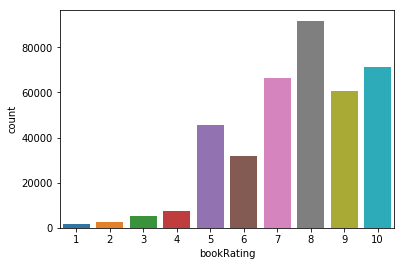

In [42]:
sns.countplot(data=ratings_explicit , x='bookRating')
#Show the counts of observations in each categorical bin using bars.
#sns.countplot能显示该列数据值的统计分

## 构建基于简单流行度的推荐系统

In [49]:
#对用户评分进行简单的叠加，
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)

In [50]:
top10

,bookRating
ISBN,
0316666343,5787
0385504209,4108
0312195516,3134
059035342X,2798
0142001740,2595
0971880107,2551
0060928336,2524
0446672211,2402
0452282152,2219


In [51]:
#推荐以下书籍
top10.merge(books, left_index=True, right_on = 'ISBN')
#merge合并
#left_index=True是否使用索引连接对应

,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


In [52]:
users_exp_ratings = users[users.userID.isin(ratings_explicit.userID)]
users_imp_ratings = users[users.userID.isin(ratings_implicit.userID)]

In [53]:
print (users.shape)
print (users_exp_ratings.shape)
print (users_imp_ratings.shape)

(278858, 3)
(68091, 3)
(52451, 3)


## 基于协同过滤的推荐系统

** 为了应对机器计算能力和减少数据量的要求，考虑评定100本书籍和100个评级的用户**

In [108]:
#userid超过100个
count1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(count1[count1>=100].index)]
#若userid存在于评分超过100个的

In [109]:
ratings_explicit.head(5)

,userID,ISBN,bookRating
1456,277427,002542730X,10
1458,277427,003008685X,8
1461,277427,0060006641,10
1465,277427,0060542128,7
1474,277427,0061009059,9


In [106]:
#评分超过100个
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 100].index)]

In [107]:
ratings_explicit.head(5)

,userID,ISBN,bookRating
1456,277427,002542730X,10
1458,277427,003008685X,8
1461,277427,0060006641,10
1465,277427,0060542128,7
1474,277427,0061009059,9


**从显式的评级表生成评级矩阵**

In [110]:
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')

In [112]:
userID = ratings_matrix.index
ISBN = ratings_matrix.columns

In [114]:
print(ratings_matrix.shape)
ratings_matrix.head()

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
#统计明确评级的用户和书籍
n_users = ratings_matrix.shape[0] #只考虑那些给出明确评级的用户
n_books = ratings_matrix.shape[1]
print (n_users, n_books)

449 66574


In [117]:
#填充空值为0
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [125]:
ratings_matrix.shape

(449, 66574)

In [124]:
#users_exp_ratings.shape[0]没有经过前100排序的
sparsity=1.0-len(ratings_explicit)/float(users_exp_ratings.shape[0]*n_books)
print ('图书交叉数据集的稀疏级别是 ' +  str(sparsity*100) + ' %')

图书交叉数据集的稀疏级别是 99.99772184106935 %


In [123]:
#重新计算一些稀疏级别
sparsity = 1.0 - len(ratings_explicit)/float(ratings_matrix.shape[0]*ratings_matrix.shape[1])#进行评分的数量与
print('图书交叉数据集的稀疏级别是 ' +  str(sparsity*100) + ' %')

图书交叉数据集的稀疏级别是 99.65451643709031 %


In [129]:
ratings_matrix.shape[0]

449

In [131]:
users_exp_ratings.shape[0]

68091

**什么是协同过滤？**    
协同过滤是利用集体智慧的一个典型方法。要理解什么是协同过滤 (Collaborative Filtering, 简称 CF)，首先想一个简单的问题，如果你现在想看个电影，但你不知道具体看哪部，你会怎么做？大部分的人会问问周围的朋友，看看最近有什么好看的电影推荐，而我们一般更倾向于从口味比较类似的朋友那里得到推荐。这就是协同过滤的核心思想。

协同过滤一般是在海量的用户中发掘出一小部分和你品位比较类似的，在协同过滤中，这些用户成为邻居，然后根据他们喜欢的其他东西组织成一个排序的目录作为推荐给你。当然其中有一个核心的问题：

* 如何确定一个用户是不是和你有相似的品位？
* 如何将邻居们的喜好组织成一个排序的目录？

协同过滤相对于集体智慧而言，它从一定程度上保留了个体的特征，就是你的品位偏好，所以它更多可以作为个性化推荐的算法思想。可以想象，这种推荐策略在 Web 2.0 的长尾中是很重要的，将大众流行的东西推荐给长尾中的人怎么可能得到好的效果，这也回到推荐系统的一个核心问题：了解你的用户，然后才能给出更好的推荐。

当已经对用户行为进行分析得到用户喜好后，我们可以根据用户喜好计算相似用户和物品，然后基于相似用户或者物品进行推荐，这就是最典型的 CF 的两个分支：基于用户的 CF 和基于物品的 CF。这两种方法都需要计算相似度，下面我们先看看最基本的几种计算相似度的方法。

　　相似度的计算

　　关于相似度的计算，现有的几种基本方法都是基于向量（Vector）的，其实也就是计算两个向量的距离，距离越近相似度越大。在推荐的场景中，在用户 - 物品偏好的二维矩阵中，我们可以将一个用户对所有物品的偏好作为一个向量来计算用户之间的相似度，或者将所有用户对某个物品的偏好作为一个向量来计算物品之间的相似度。下面我们详细介绍几种常用的相似度计算方法：

**设定函数找到k个相似的用户，给定用户id和评级矩阵**

In [134]:
def findsimilarusers(user_id, ratings, metric = metric, k = k):
    similarties = []
    indices = []
    model_knn = NearestNeighbors(metric = metric, algorithm='brute')
    #from sklearn.neighbors import NearestNeighbors
    #用途Unsupervised learner for implementing neighbor searches.无监督的学习器实现近邻搜索

NameError: name 'metric' is not defined

In [138]:
ratings_matrix

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
users_exp_ratings

,userID,Location,Age
7,8,"timmins, ontario, canada",34
8,9,"germantown, tennessee, usa",34
11,12,"fort bragg, california, usa",34
13,14,"mediapolis, iowa, usa",34
15,16,"albuquerque, new mexico, usa",34
16,17,"chesapeake, virginia, usa",34
18,19,"weston, ,",14
21,22,"erfurt, thueringen, germany",34
25,26,"bellevue, washington, usa",34
31,32,"portland, oregon, usa",34


In [141]:
def findksimilarusers(user_id, ratings, metric, k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    #brute’ 使用蛮力搜索.
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities, indices

In [142]:
def predict_userbased(user_id, item_id, ratings, metric, k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #在非常稀疏的数据集的情况下，使用基于协作的方法的相关度量可能会给出负面的评价
    #在这里的处理如下
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('用户预测等级 {0} -> item {1}: {2}'.format(user_id,item_id,prediction))
 
    return prediction

In [143]:
predict_userbased(11676,'0001056107',ratings_matrix)

TypeError: predict_userbased() missing 2 required positional arguments: 'metric' and 'k'